# Recent Alignment Experiments for Matrix Factorization

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import train_utils as train
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in l

## function defs

In [2]:
class FCNLayer(train.BaseLayer):
    
    def __init__(self, n, init_val, init_vec=None):
        super(FCNLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n, n)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))

class DeepFCN(train.DeepNet):
    
    def __init__(self, n, depth, init_vec=None):
        super(DeepFCN, self).__init__(n, depth)
        self.init_val = 1e-1
        
        if init_vec is None:
            self.layers = nn.ModuleList([FCNLayer(n, self.init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([FCNLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

In [44]:
# calculates alignment in the case of matrix factorization
def alignment(net, A, debug=False):

    u_vals = []
    vh_vals = []
    
    for layer in net.layers:
        u, s, vh = np.linalg.svd(layer.weight_matrix().detach().numpy())
        u_vals.append(u)
        vh_vals.append(vh)
        
    total_alignment = 0
    
    u_A, s_A, vh_A = np.linalg.svd(A)
    
    res = np.matmul(u_A.transpose(), u_vals[-1])
    for j in range(net.n):
        total_alignment += max([abs(k) for k in res[j]])
        
    if debug:
        print(total_alignment)
    
    res = np.matmul(vh_vals[0], vh_A.transpose())
    for j in range(net.n):
        total_alignment += max([abs(k) for k in res[j]])
    
    if debug:
        print(total_alignment)
    
    if len(net.layers) > 1:
        for i in range(len(net.layers) - 1):

            res = np.matmul(vh_vals[i+1], u_vals[i])
            for j in range(net.n):
                total_alignment += max([abs(k) for k in res[j]])
                
    if debug:            
        print(total_alignment)
    
    return total_alignment/float((len(net.layers) + 1)*net.n)


In [37]:
# A is an input matrix we're trying to factor
def factor(A, net):
    size = len(A)
    
    optimizer = optim.SGD(net.parameters(), lr = 1e-2)
    criterion = nn.MSELoss()
    
    loss_val = 1
    data = [np.array([1. if i == j else 0. for i in range(size)]) for j in range(size)]

    y = torch.Tensor([np.matmul(A, x) for x in data]).view(len(data), size)
    x = torch.Tensor(data).view(len(data), size)
    i = 0
    align_vals = []
    losses = []
    svals = []
    print(np.linalg.svd(net.weight_matrix().detach().numpy())[1])
    while loss_val > 1e-6 and i < 5e4:
        optimizer.zero_grad()
        pred = net(x)
        align = alignment(net, A)
        align_vals.append(align)

        loss = criterion(y, pred)
        loss.backward()
        optimizer.step()
        loss_val = loss.data.item()
        losses.append(loss_val)
        svals.append(np.linalg.svd(net.layers[0].weight_matrix().detach().numpy())[1])
        if i % 1000 == 0:
            print(loss_val)
        i += 1
    return [i.weight_matrix().detach().numpy() for i in net.layers], losses, align_vals, svals

## initial fcn experiments

[ 3.28829644  1.93122589  1.60658275  1.11674863  0.86031151  0.05797852]
[  3.55559997e-02   7.20276404e-03   4.14676405e-03   1.39272772e-03
   6.36747398e-04   1.94572024e-07]
0.5232335329055786
0.4505167603492737
0.22567695379257202
0.21573665738105774
0.16389049589633942
0.11343949288129807
0.07983728498220444
0.05508632957935333
0.054243333637714386
0.053619906306266785
0.0523882657289505
0.04966772347688675
0.043171484023332596
0.030440134927630424
0.021397801116108894
0.0201619490981102
0.0199185311794281
0.01959090307354927
0.01904822327196598
0.01809687167406082
0.01634463295340538
0.013088272884488106
0.007814552634954453
0.002567002549767494
0.00045198635780252516
0.0001242468715645373
9.555472934152931e-05
9.352091001346707e-05
9.338484233012423e-05
9.337590745417401e-05
9.337541996501386e-05
9.337519441032782e-05
9.337530354969203e-05
9.337538358522579e-05
9.337516530649737e-05
9.337523806607351e-05
9.337516530649737e-05
9.337528172181919e-05
9.33753399294801e-05
9.337541

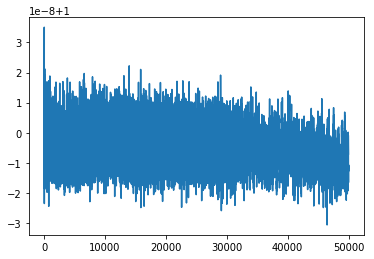

In [51]:
size = 6
depth = 3 
A = 0.5*np.random.randn(size, size)
for i in range(size):
    for j in range(i):
        A[i][j] = A[j][i]
A = np.matmul(A, A)
print(np.linalg.svd(A)[1])

net = DeepFCN(size, depth, init_vec = 0.1*A)

factors, losses, align_vals, svals = factor(A, net)
plt.plot(align_vals)

Text(0.5,0,'step')

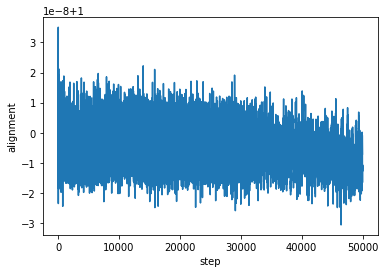

In [52]:
plt.plot(align_vals)
plt.ylabel("alignment")
plt.xlabel("step")

Text(0.5,0,'step')

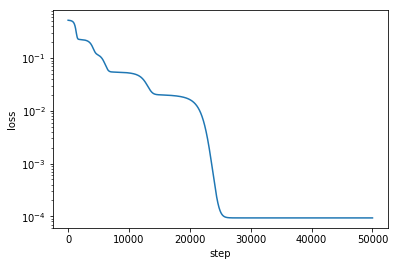

In [53]:
plt.plot(losses)
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("step")

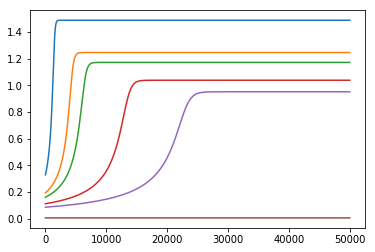

In [54]:
plt.plot(svals)

## Fully Connected networks stay aligned, while convolutional do not

In [56]:
# encode a 3x3 matrix
class ConvLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        # n has to equal 9 for now
        super(ConvLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(9)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return F.linear(input, self.weight_matrix())
    
    def weight_matrix(self):
        rows = [
            torch.cat([self.weight.narrow(0, 4, 2), torch.zeros(1), self.weight.narrow(0, 7, 2), torch.zeros(4)]),
            torch.cat([self.weight.narrow(0, 3, 6), torch.zeros(3)]),
            torch.cat([torch.zeros(1), self.weight.narrow(0, 3, 2), torch.zeros(1), self.weight.narrow(0, 6, 2), torch.zeros(3)]),
            torch.cat([self.weight.narrow(0, 1, 2), torch.zeros(1), self.weight.narrow(0, 4, 2), torch.zeros(1), self.weight.narrow(0, 7, 2), torch.zeros(1)]),
            self.weight,
            torch.cat([torch.zeros(1), self.weight.narrow(0, 0, 2), torch.zeros(1), self.weight.narrow(0, 3, 2), torch.zeros(1), self.weight.narrow(0, 6, 2)]),
            torch.cat([torch.zeros(3), self.weight.narrow(0, 1, 2), torch.zeros(1), self.weight.narrow(0, 4, 2), torch.zeros(1)]),
            torch.cat([torch.zeros(3), self.weight.narrow(0, 0, 6)]),
            torch.cat([torch.zeros(4), self.weight.narrow(0, 0, 2), torch.zeros(1), self.weight.narrow(0, 3, 2)])
        ]
        return torch.stack(rows, dim = 1)
                            
class DeepConv(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepConv, self).__init__(n, depth)

        init_val = 0.1
        if init_vec is None:
            self.layers = nn.ModuleList([ConvLayer(n, init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ConvLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

In [57]:
# 3 by 3 image, i.e. 9 x 9 matrix we are factorizing
n = 9
depth = 2
# same initialization for all layers so that they begin aligned
init_vec = 0.01*np.random.normal(size=9)
init_vec[8] = init_vec[0]
init_vec[7] = init_vec[1]
init_vec[6] = init_vec[2]
init_vec[5] = init_vec[3]
conv = DeepConv(n, depth, init_vec = init_vec)

init = conv.layers[1].weight_matrix().detach().numpy()

Q = np.linalg.eig(init)[1]

# A must be symmetric, psd, with eigenvalues aligned to the initialization
A = np.matmul(np.matmul(Q, np.diag(0.5*np.ones(n) + np.random.rand(n))), Q.transpose())
print(A)

[[ 1.2413624   0.05637512 -0.05716242 -0.00347195  0.10113553  0.14917197
   0.011579   -0.1844472  -0.07748498]
 [ 0.05637512  1.05946198  0.2171448   0.09517495  0.13772006 -0.01592294
  -0.14233662  0.00411899 -0.1844472 ]
 [-0.05716242  0.2171448   1.00766107  0.12913122 -0.01504026 -0.03529943
   0.17974161 -0.14233662  0.011579  ]
 [-0.00347195  0.09517495  0.12913122  1.16111626 -0.02885541 -0.03170965
  -0.03529943 -0.01592294  0.14917197]
 [ 0.10113553  0.13772006 -0.01504026 -0.02885541  0.97760316 -0.02885541
  -0.01504026  0.13772006  0.10113553]
 [ 0.14917197 -0.01592294 -0.03529943 -0.03170965 -0.02885541  1.16111626
   0.12913122  0.09517495 -0.00347195]
 [ 0.011579   -0.14233662  0.17974161 -0.03529943 -0.01504026  0.12913122
   1.00766107  0.2171448  -0.05716242]
 [-0.1844472   0.00411899 -0.14233662 -0.01592294  0.13772006  0.09517495
   0.2171448   1.05946198  0.05637512]
 [-0.07748498 -0.1844472   0.011579    0.14917197  0.10113553 -0.00347195
  -0.05716242  0.05637

In [59]:
_, losses_conv, align_conv, svals_conv = factor(A, conv)

[  6.35829929e-04   6.01889798e-04   5.89764619e-04   5.44570386e-04
   4.15417016e-04   3.58267775e-04   5.46116644e-06   1.29846455e-06
   3.71010998e-07]
0.14608128368854523
0.14418046176433563
0.1063147559762001
0.06487222015857697
0.05783170461654663
0.05545487999916077
0.05511695519089699
0.055057261139154434
0.05501371994614601
0.05497083067893982
0.05492774397134781
0.05488432198762894
0.05484050512313843
0.05479627847671509
0.05475165694952011
0.05470672622323036
0.05466156080365181
0.054616328328847885
0.05457120016217232
0.05452639237046242
0.05448218807578087
0.05443885549902916
0.05439669266343117
0.05435596778988838
0.054316937923431396
0.05427972227334976
0.05424416437745094
0.05420923978090286
0.054171521216630936
0.05412070453166962
0.05402657389640808
0.053802985697984695
0.05321616306900978
0.05171489715576172
0.04845245182514191
0.043519552797079086
0.03917956352233887
0.03686566650867462
0.0358765684068203
0.035421982407569885
0.03516336902976036
0.0349824763834476

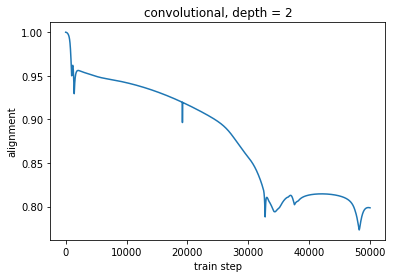

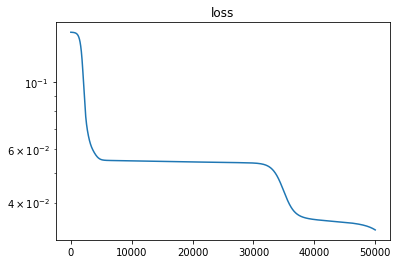

In [65]:
plt.plot(align_conv)
plt.title("convolutional, depth = 2")
plt.ylabel("alignment")
plt.xlabel("train step")
plt.show()
plt.plot(losses_conv)
plt.yscale("log")
plt.title("loss")
plt.show()

In [66]:
# initialize fully connected network the same as we did the convolutional
net = DeepFCN(n, depth, init_vec = init)

In [67]:
_, losses_fcn, align_fcn, svals_fcn = factor(A, net)

[  6.35829929e-04   6.01889798e-04   5.89764619e-04   5.44570386e-04
   4.15417016e-04   3.58267775e-04   5.46116644e-06   1.29846455e-06
   3.71010998e-07]
0.14608128368854523
0.14601564407348633
0.1458955854177475
0.14567406475543976
0.1452624797821045
0.14449554681777954
0.1430710256099701
0.14046591520309448
0.13587546348571777
0.12835955619812012
0.11749771237373352
0.10432640463113785
0.09115567803382874
0.07988323271274567
0.07087339460849762
0.06331142783164978
0.05607081204652786
0.04826594889163971
0.03975975885987282
0.03160865977406502
0.025018366053700447
0.019773438572883606
0.014961844310164452
0.010468554683029652
0.006956508848816156
0.004835602827370167
0.0038267038762569427
0.003417131258174777
0.0032562881242483854
0.0031825623009353876
0.0031344364397227764
0.003089631674811244
0.003039218485355377
0.0029784515500068665
0.0029038293287158012
0.0028122093062847853
0.0027006184682250023
0.0025664553977549076
0.0024078551214188337
0.0022242835257202387
0.0020171173382

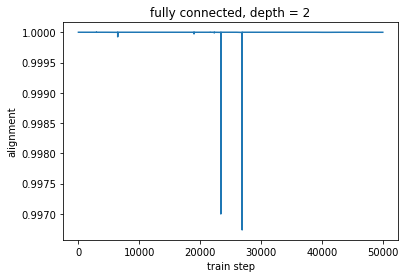

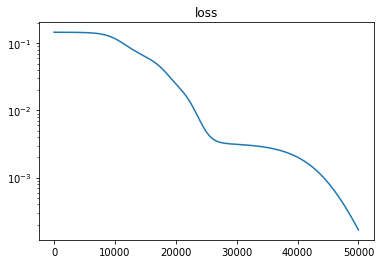

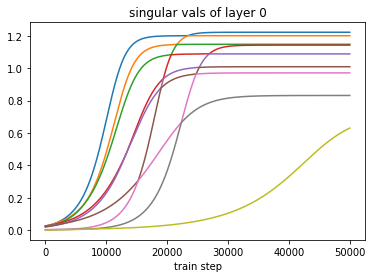

In [69]:
plt.plot(align_fcn)
plt.title("fully connected, depth = 2")
plt.ylabel("alignment")
plt.xlabel("train step")
plt.show()

plt.plot(losses_fcn)
plt.yscale("log")
plt.title("loss")
plt.show()

plt.plot(svals_fcn)
plt.title("singular vals of layer 0")
plt.xlabel("train step")
plt.show()

# Initialized as aligned becomes unaligned for random data (TODO)

# Randomly initialized matrix factorization eventually becomes aligned

### (this isn't working for some reason...)

In [70]:
n = 9
depth = 2
A = 0.5*np.random.randn(n, n)
net = DeepFCN(n, depth)
_, losses_fcn, align_fcn, svals_fcn = factor(A, net)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[ 0.2269568   0.13798711  0.12111852  0.10683064  0.05725367  0.05144684
  0.02007536  0.01012531  0.00050063]
0.22581590712070465
0.20296986401081085
0.17142988741397858
0.1286533623933792
0.08351124078035355
0.04936863109469414
0.029994234442710876
0.019660232588648796
0.013629771769046783
0.00991151761263609
0.007674778811633587
0.006380900740623474
0.005611828528344631
0.005095417145639658
0.004687107168138027
0.004320155363529921
0.003966536372900009
0.003615922061726451
0.0032662120647728443
0.002919306280091405
0.002579200780019164
0.0022508110851049423
0.0019392562098801136
0.0016491235001012683
0.0013841746840626001
0.0011469499440863729
0.000938656332436949
0.000759198097512126
0.0006073670228943229
0.0004810684476979077
0.0003776512457989156
0.0002941428392659873
0.00022754912788514048
0.00017502221453469247
0.00013398457667790353
0.00010216749069513753
7.766847556922585e-05
5.8906105550704524e-05
4.459765841602348e-05
3.372353967279196e-05
2.547937947383616e-05
1.9243030692

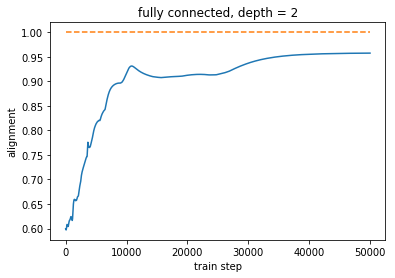

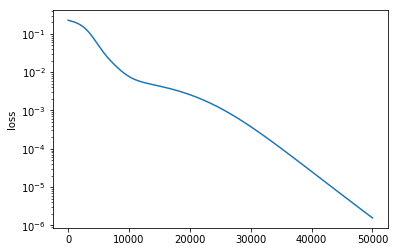

In [71]:
plt.plot(align_fcn)
plt.plot([0, len(align_fcn)], [1.0, 1.0], '--')
plt.title("fully connected, depth = 2")
plt.ylabel("alignment")
plt.xlabel("train step")
plt.show()

plt.ylabel("loss")
plt.yscale("log")
plt.plot(losses_fcn)
plt.show()

## Random data does not become aligned

In [72]:
# only check alignment between weight matrices, not data
def alignment_rand(net):
    u_vals = []
    vh_vals = []
    
    for layer in net.layers:
        u, s, vh = np.linalg.svd(layer.weight_matrix().detach().numpy())
        u_vals.append(u)
        vh_vals.append(vh)
        
    total_alignment = 0
    
    if len(net.layers) > 1:
        for i in range(len(net.layers) - 1):

            res = np.matmul(vh_vals[i+1], u_vals[i])
            for j in range(net.n):
                total_alignment += max([abs(k) for k in res[j]])
    
    return total_alignment/float((len(net.layers) - 1)*net.n)

In [73]:
def factor_rand(x, y, net):
    
    optimizer = optim.SGD(net.parameters(), lr = 1e-2)
    criterion = nn.MSELoss()
    
    loss_val = 1
    i = 0
    align_vals = []
    losses = []
    svals = []
    print(np.linalg.svd(net.weight_matrix().detach().numpy())[1])
    while loss_val > 1e-6 and i < 5e4:
        optimizer.zero_grad()
        pred = net(x)
        align = alignment_rand(net)
        align_vals.append(align)

        loss = criterion(y, pred)
        loss.backward()
        optimizer.step()
        loss_val = loss.data.item()
        losses.append(loss_val)
        svals.append(np.linalg.svd(net.layers[0].weight_matrix().detach().numpy())[1])
        if i % 1000 == 0:
            print(loss_val)
        i += 1
    return [i.weight_matrix().detach().numpy() for i in net.layers], losses, align_vals, svals

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[ 0.26480496  0.1391837   0.11223449  0.05950027  0.03881624  0.02628512
  0.01587727  0.00989273  0.00667565]
0.8095195293426514
0.24537880718708038
0.11472931504249573
0.06350760161876678
0.0363214910030365
0.021484456956386566
0.011851543560624123
0.005828684661537409
0.002658486133441329
0.0011975973611697555
0.0005529210902750492
0.0002633263939060271
0.0001284778700210154
6.37167104287073e-05
3.195067256456241e-05
1.615092514839489e-05
8.216863534471486e-06
4.203310254524695e-06
2.1613245735352393e-06
1.1182077059856965e-06


Text(0.5,0,'train step')

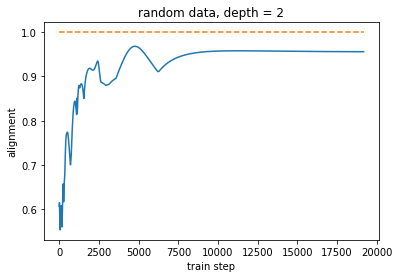

In [74]:
x = torch.randn(n, n)
y = torch.randn(n, n)
net = DeepFCN(n, depth)
_, losses_rand, align_rand, svals_rand = factor_rand(x, y, net)


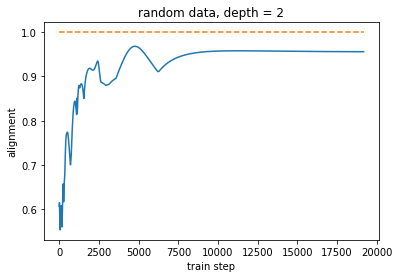

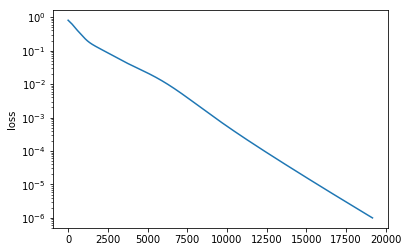

In [75]:
plt.plot(align_rand)
plt.plot([0, len(align_rand)], [1.0, 1.0], '--')
plt.title("random data, depth = 2")
plt.ylabel("alignment")
plt.xlabel("train step")
plt.show()

plt.ylabel("loss")
plt.yscale("log")
plt.plot(losses_rand)
plt.show()